In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,AutoModel,
                          DistilBertTokenizer, DistilBertModel,AutoModelForSeq2SeqLM,AutoConfig)

from shopee_utils import *
from train_utils import *
import codecs

In [3]:
import debugpy
#debugpy.listen(5678)

In [28]:
BERT_MODEL_CLASS = AutoModel
BERT_TOKENIZER_CLASS = BertTokenizer
class CONF(ConfigClass):
    bert_path ='./indobert-large-p2'
    arcface_m = .5
    arcface_s = 30
    lr = 1e-2
    lr_mult = 100
    train_epochs = 8
    train_freeze_epochs = 1
    droput_p = .25
    embs_dim = 1024
    tokens_max_length = 80
    adam_mom=.9
    adam_sqr_mom=.99
    adam_eps=1e-5
    adam_wd=0.01
    use_argmargin=False
    arc_easymargin=False
    label_smooth=.1
    batch_size = 64
    experiment_id=0
    
    def toDict(self):
        return {k:self.__getattribute__(k) for k in dir(self) if k[:2]!='__' and not inspect.isroutine(self.__getattribute__(k))}
    
    def __repr__(self):
        return str(self.toDict())
    
    def foo():
        return CONF()
config = CONF()

In [5]:
# PATH = Path('../input/shopee-product-matching')
# model_file  = '../input/resnet-model/bert814.pth'
# if not PATH.is_dir():
#     PATH = Path('/home/slex/data/shopee')
#     model_file ='models/bert814.pth'
#BERT_PATH = './bert_indonesian' #.823
#BERT_PATH='bert-base-multilingual-cased'
#BERT_PATH='bert-base-cased'
#BERT_PATH='cahya/distilbert-base-indonesian'
#BERT_PATH='indobenchmark/indobert-base-p1' #.815
#BERT_PATH='indobenchmark/indobert-base-p2'  #.817
#BERT_PATH='indobenchmark/indobert-large-p1' #.829
#BERT_PATH='indobenchmark/indobert-large-p2' #.828
#BERT_PATH='indobenchmark/indobert-lite-large-p2'#.768


# BertModelClass = AutoModel
# BertTokenizerClass = BertTokenizer

In [6]:
train_df = pd.read_csv(PATH/'train_split.csv', encoding='utf_8')
train_df['is_valid'] = train_df.split==0

In [7]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.initial_layers=nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(config.droput_p))
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x = self.initial_layers(x)
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    


In [9]:
class BertArcFace(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
        self.classifier = ArcFaceClassifier(config.embs_dim, dls.c)
        self.outputEmbs = False
    def forward(self, x):
        output = self.bert_model(*x)
        last_hidden =output.last_hidden_state[:,0,:]
        embeddings=last_hidden
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)


In [10]:
class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BERT_TOKENIZER_CLASS.from_pretrained(config.bert_path)
        
        
    def encodes(self, row):
        text = row.title
        text=(codecs.decode(text, 'unicode_escape'))
        encodings = self.tokenizer(text, padding = 'max_length', max_length=config.tokens_max_length,
                                   truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask']#, 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

In [11]:
tfm = TitleTransform()

data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=tfm), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
dls = data_block.dataloaders(train_df, bs=config.batch_size)


In [12]:
def new_model():
    bert_model = BERT_MODEL_CLASS.from_pretrained(config.bert_path)
    return BertArcFace(bert_model)

In [13]:
def split_2way(model):
    return L(params(model.bert_model),
            params(model.classifier))

In [14]:
f1_tracker = TrackerCallback(monitor='F1 embeddings', comp=np.greater)

In [15]:
opt_func=RMSProp

In [16]:

loss_func=functools.partial(arcface_loss, m=config.arcface_m, s=config.arcface_s)
#opt_func=functools.partial(Adam, mom=.9, sqr_mom=.99, eps=1e-5, wd=0.01)
learn = Learner(dls,new_model(), opt_func=opt_func, splitter=split_2way, loss_func=loss_func,  
                cbs = [F1FromEmbs, f1_tracker],metrics=FakeMetric())

In [17]:
learn.fine_tune(config.train_epochs, config.lr, freeze_epochs=config.train_freeze_epochs, lr_mult=config.lr_mult)

epoch,train_loss,valid_loss,F1 embeddings,time
0,19.851463,None,0.781068,02:27


epoch,train_loss,valid_loss,F1 embeddings,time
0,17.857679,None,0.807170,03:36
1,14.733889,None,0.821431,03:29
2,12.128552,None,0.826417,03:23
3,9.717164,None,0.829441,03:23
4,7.572951,None,0.831240,03:23
5,6.029807,None,0.828202,03:23
6,4.994781,None,0.830626,03:23
7,4.477943,None,0.830180,03:23


In [77]:
best_f1=f1_tracker.best
print(best_f1)

0.8046468428191103


In [ ]:
learn.load('bert823val')

In [18]:
learn.save('bertlarge829val')

Path('models/bertlarge829val.pth')

## Validataion set

In [29]:
embs_model = learn.model.eval()
embs_model.outputEmbs = True

In [30]:
valid_embs, _ = embs_from_model(embs_model, dls.valid)

  0%|          | 0/107 [00:00<?, ?it/s]

In [31]:
dists, inds = get_nearest(valid_embs, do_chunk(valid_embs))

In [32]:
valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

In [33]:
pairs = sorted_pairs(dists, inds)[:len(valid_df)*10]

0.830 at 6.4878082275390625 pairs or 0.568 threshold


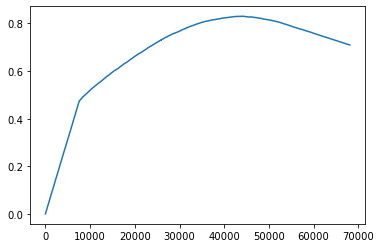

In [34]:
_=build_from_pairs(pairs, valid_df.target.to_list())

In [36]:
torch.save(learn.model.bert_model.state_dict(), 'models/bert_large_state.pth')